# Looking at the MUSE data for LLS sight lines

Use this notebook to look at / build up the techniques for dealing with the MUSE data Lorrie Straka has given us.

[Read in the MUSE data](#Read-in-the-MUSE-data) / [Plot the MUSE data](#Plot-the-MUSE-data)

[H-beta, \[O III\] fitting](#A.-H$\beta$,-O-III-fitting) / [\[O II\] fitting](#B.-[O-II]-fitting)

[Integrated fluxes, errors](#Integrated-fluxes-and-errors)

[Results for SFR, Metallicity](#Making-use-of-these-results)

[Mg II Absorption](#Mg-II-absorption)

[Lehner talk plot](#Lehner-talk-plot)

**[Summary of results](#Summary-of-results)**

[Set-up pyMCZ files](#Set-up-pyMCZ-input-files:)

## Standard set-up:

In [24]:
import matplotlib.pyplot as plt

import numpy as np

from astropy.io import fits
from astropy.io import ascii

from astropy import units as u
from astropy import constants as const

import sys

## Read in the MUSE data
**Be aware:** the MUSE output data are stored as *air* wavelengths.

* Read and extract the spectrum (this process is specific to MUSE)

In [25]:
input_file = 'Data/PG1522+101_OBJ143.fits'
pg1522=fits.open(input_file)

# Create wavelength, flux, error vectors --> specific to MUSE.
delLambda=pg1522[1].header['cdelt1']
lambda0=pg1522[1].header['crval1']

wave = lambda0+np.arange(pg1522[1].data.size)*delLambda
flux = pg1522[1].data*1.e-20
variance = pg1522[2].data*1.e-40

err = np.sqrt(variance)

## Plot the MUSE data


In [26]:
figXsize=8
figYsize=4.5

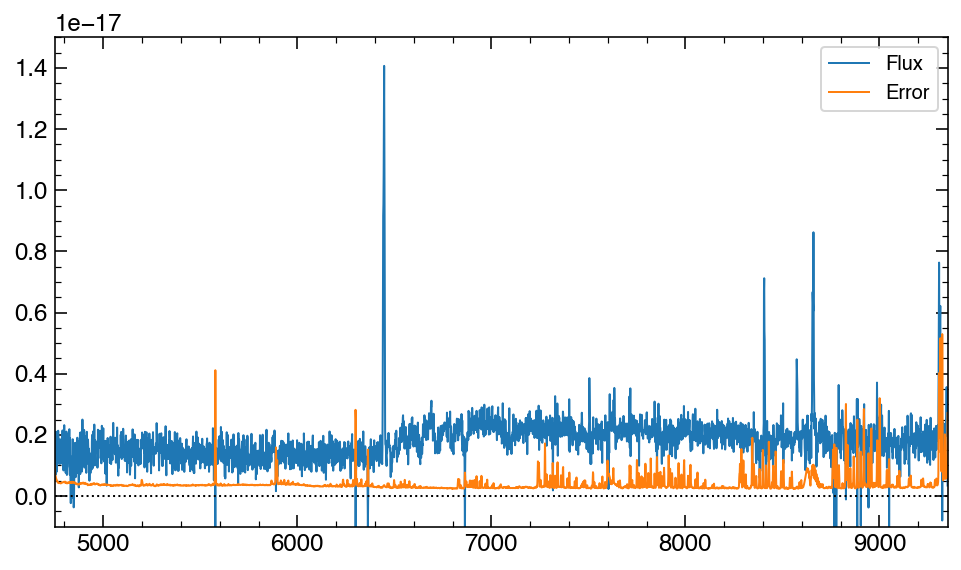

In [27]:
fig = plt.figure(figsize=(figXsize,figYsize))
ax = fig.add_subplot(111)
ax.plot(wave,flux,label='Flux',lw=1)
ax.plot(wave,flux*0.,'k:',lw=1)
ax.set_xlim([wave.min(),wave.max()])
ax.set_ylim([-0.1e-17,1.5e-17])
ax.plot(wave,np.sqrt(variance),label='Error',lw=1)
ax.legend()

## Fit the data

We'll be following the fitting tutorial from the AAS python tutorials: [Modeling](https://github.com/spacetelescope/AAS2016/blob/master/notebooks/aas2016_Modeling.ipynb), [Modeling Exercise Solutions](https://github.com/spacetelescope/AAS2016/blob/master/notebooks/aas2016_Modeling_solutions.ipynb) . The full AAS tutorial is here: [Using Python for Astronomical Data Analysis](https://github.com/spacetelescope/AAS2016) .)

#### Set up some quantities that are needed to analyze the data


We are going to assume an initial redshift guess: z=0.7292.

In [28]:
z_init=0.7292
scaleFactor=(1+z_init)

zwave = wave/scaleFactor

We are interested in a subset of the following wavelengths.

In [29]:
#Wavelengths:
Hgamma = 4340.471 
Hbeta = 4861.333 ##Air
Halpha = 6562.819
OIIa = 3726.032 ##Air
OIIb = 3728.815 ##Air
OIIIa = 4958.911
OIIIb = 5006.843

##Old: vacuum wavelengths?
#Hbeta = 4862.721 ##Vac?
#OIIIb = 5008.239 ##Vac?
#NaIa = 6549.86
#NaIb = 6585.27
#SIIa = 6718.29
#SIIb = 6732.68

In a few cases, we're also interested in the transition probabilities.

In [30]:
#Transition Probabilities
a3726=1.86e-05+1.59e-04
a3728=1.98e-06+2.86e-05

a4959=6.21e-03
a5006=1.81e-02

### Set up the fitting

In [31]:
from astropy.modeling import models, fitting

fitter = fitting.LevMarLSQFitter()
linfitter = fitting.LinearLSQFitter()

### A. H$\beta$, O III fitting

Our first model is going to fit H-beta, [OIII] 4959, 5007 only. We will separately work out a fit for the [O II] later. (I'm separating the two regions because of the 4000 Å break between them, which makes a single continuum fit more difficult to work out.)

We need to define the spectral region to be fit, which will be 80 Å from either side of the lines to be fitted. (This choice is arbitrary, chosen in order to exclude areas of bad sky subtraction, spectral regions that are unimportant and disconnected from our particular lines.)

#### Set up our variables for fitting

In [32]:
#Define the indeces over the region of interest:
fitWaves1 = ((zwave >= (Hbeta - 80.)) & (zwave <= (OIIIb+80.)))
print(fitWaves1.sum(),zwave.size)

422 3682


Extract the actual wavelengths. Note the use of the values, which removes the units (important for when we pass it to the `set_xlim` command later).

In [33]:
waveLimits1=[wave[fitWaves1].min(),wave[fitWaves1].max()]
waveLimits1

[8268.7060546875, 8794.9560546875]

We want to fit the *continuum*, meaning we have to remove strong emission/absorption lines. We do this by calculating the local mean and rejecting points >2$\sigma$ from the mean.

In [34]:
mean_flux = flux[fitWaves1].mean()
#cont = np.where((np.abs(flux-mean_flux) > 2.*err) & (flux > 0), mean_flux, flux)
cont = np.where(np.abs(flux-mean_flux) > 2.*err, mean_flux, flux)

#### Set-up and check the continuum fitting process:
Our continuum model is going to make use of Chebychev polynomials. To do this, we first start by initializing a model continuum.

In [35]:
#cheb1 = models.Chebyshev1D(degree=3, c0=1, c1=1, c2=1, c3=1)
cheb1 = models.Chebyshev1D(degree=3)

* *Fit the continuum:* Note that the end result is a function `cheb_cont1` that takes the a wavelength array as input and returns the continuum fit.

In [36]:
cheb_cont1 = linfitter(cheb1, wave[fitWaves1], cont[fitWaves1])

* *Check the fitting process:*

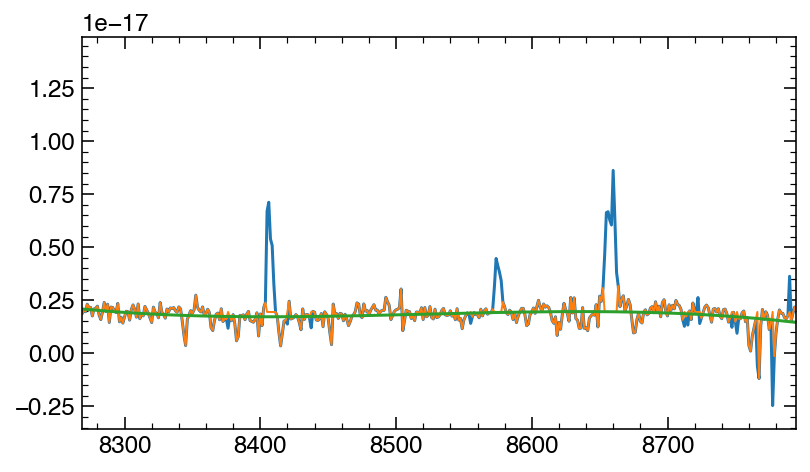

In [37]:
fig = plt.figure(figsize=(figXsize*0.8,figYsize*0.8))
ax = fig.add_subplot(111)
ax.plot(wave,flux)
ax.set_xlim(waveLimits1)

ax.plot(wave,cont,linewidth=1)
ax.plot(wave[fitWaves1],cheb_cont1(wave[fitWaves1]),lw=1.5)

#### Set-up the line fitting process:
Our lines are modeled as single Gaussian functions. We need to initialize the H-beta, [O III] emission lines. 

The initialization requires intial guesses to the amplitudes, wavelengths, and sigmas. For the central wavelengths we adopt the emission line rest wavelengths modified through our initial redshifts through the `scaleFactor`. For the emission lines we'll just adopt the maximum flux over our wavelength range.

In [38]:
amplitudeInitial = flux[fitWaves1].max()*0.5
h_beta = models.Gaussian1D(amplitude=amplitudeInitial, mean=Hbeta*scaleFactor, 
                           stddev=5,name='h_beta')
o3a = models.Gaussian1D(amplitude=amplitudeInitial, mean=OIIIa*scaleFactor, 
                        stddev=3,name='o3a')
o3b = models.Gaussian1D(amplitude=amplitudeInitial, mean=OIIIb*scaleFactor, 
                        stddev=3,name='o3b')

#### Define the combined continuum and line fit:
Now let's combine all of the models in this region: H$\beta$ and [O III] lines as well as  the continuum. 

As a check, I'm going to print the parameters of the models so I have them as a reference for later.

In [39]:
combinedFit1 = h_beta + o3a + o3b + cheb_cont1
#combinedFit1.param_names

#### Apply physical constraints to fit parameters

We constrain some of the fit parameters to physical values. In particular:

1) The ratio of O III lines is as expected from atomic physics!

In [40]:
def tie_OIIIratio(model):
    return model.amplitude_2*a4959/a5006

combinedFit1.amplitude_1.tied = tie_OIIIratio

2) The redshifts of the lines should all be the same.

In [41]:
def tie_waveA(model):
    return model.mean_0 * OIIIa/Hbeta
def tie_waveB(model):
    return model.mean_0 * OIIIb/Hbeta

combinedFit1.mean_1.tied = tie_waveA
combinedFit1.mean_2.tied = tie_waveB

3) The dispersion of the O III lines should be the same.

In [42]:
def tie_sigma(model):
    return model.stddev_2
#tie_sigma(combinedFit1)

combinedFit1.stddev_1.tied = tie_sigma

#### Define the fitter for the total model and do the fit

In [43]:
fitted_model = fitter(combinedFit1, 
                      wave[fitWaves1], flux[fitWaves1],
                      weights=1./variance[fitWaves1],
                      maxiter=500)
fitted_lines = fitted_model(wave)
fitter.fit_info['message']
#fitted_model.tied

'The relative error between two consecutive iterates is at most 0.000000'

In [44]:
print(fitted_model['o3a'],fitted_model['o3b'])

Model: Gaussian1D
Name: o3a
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          amplitude               mean             stddev      
    ---------------------- ----------------- ------------------
    2.3229371948915855e-18 8575.251132929749 2.2464792759342593 Model: Gaussian1D
Name: o3b
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          amplitude              mean             stddev      
    --------------------- ----------------- ------------------
    6.770557685593833e-18 8658.138068650835 2.2464792759342593


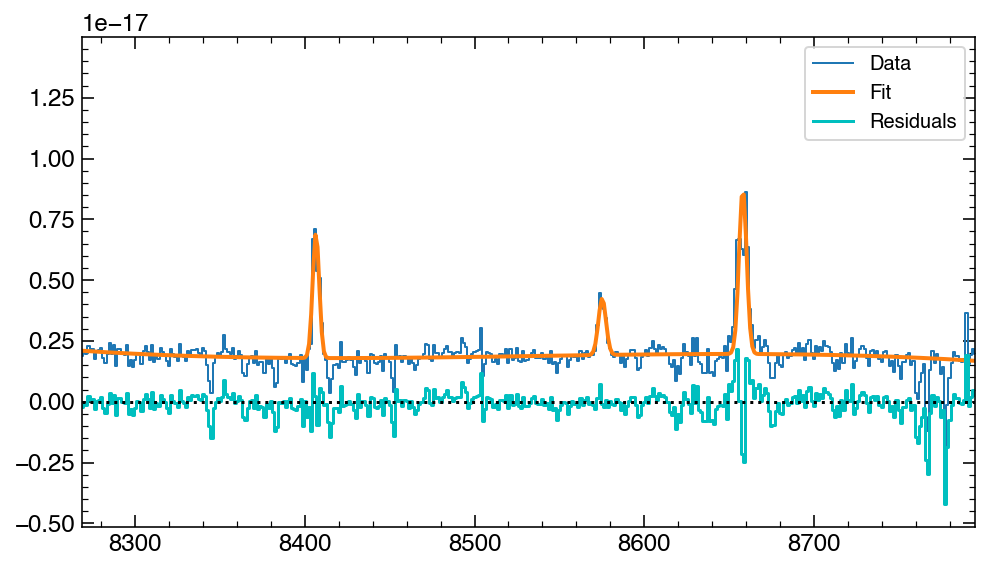

In [45]:
fig = plt.figure(figsize=(figXsize,figYsize))
ax = fig.add_subplot(111)

ax.plot(wave,flux,lw=1.,drawstyle='steps-mid',label='Data')
ax.set_xlim(waveLimits1)

#ax.plot(wave,cont)
ax.plot(wave[fitWaves1],fitted_model(wave[fitWaves1]),
        lw=2,label='Fit')
ax.plot(wave[fitWaves1],
        flux[fitWaves1]-fitted_model(wave[fitWaves1]),
        c='c',drawstyle='steps-mid',label='Residuals')
ax.plot(waveLimits1,[0.,0],':k')
ax.legend()

$\rightarrow$ *Note:* This approach does not account for potential stellar absorption under the H$\beta$ line.

In [46]:
##fitted_model[0], fitted_model[1], fitted_model[2]
#fitted_model.tied

```
```
* Calculate the redshift based on the H$\beta$ line. We've tied all the fitted central wavelengths together so that they have the same redshift, so it doesn't matter which we use.

In [47]:
z_out = (fitted_model.mean_0 / Hbeta)-1.
print(z_out)
print((z_out-z_init)/(1+z_init)*const.c.to('km/s'))

0.729260947197832
10.566452837305963 km / s


* Calculate the Hbeta, O III fluxes

In [48]:
fluxHbeta = np.sqrt(2.*np.pi)*fitted_model.amplitude_0*fitted_model.stddev_0
fluxOIIIa = np.sqrt(2.*np.pi)*fitted_model.amplitude_1*fitted_model.stddev_1
fluxOIIIb = np.sqrt(2.*np.pi)*fitted_model.amplitude_2*fitted_model.stddev_2
fluxOIII = fluxOIIIa + fluxOIIIb

In [49]:
fluxHbeta,fluxOIIIa,fluxOIIIb,fluxOIII,fluxOIII/fluxHbeta

(2.4993942344740975e-17,
 1.3080664858008536e-17,
 3.8125609328495095e-17,
 5.120627418650363e-17,
 2.0487473916766095)

In [50]:
##Diagnostics:
#print(fitted_model.submodel_names)
#print(fitted_model['o3b'])

### B. [O II] fitting
In this case, we now assume a redshift:

In [51]:
scaleFactorOut = (1.+z_out)
zwave = wave/(1.+z_out)

In [52]:
#Define the indeces for the fit region
fitWaves2 = ((zwave >= (OIIa - 80.)) & (zwave <= (OIIb+80.)))

waveLimits2=[wave[fitWaves2].min(),wave[fitWaves2].max()]

In [53]:
mean_flux2 = flux[fitWaves2].mean()
#cont2 = np.where((np.abs(flux-mean_flux) > 2.*err) & (flux > 0), mean_flux, flux)
cont2 = np.where(np.abs(flux-mean_flux2) > 2.*err, mean_flux2, flux)

#### Set-up and check the continuum fitting process:

In [54]:
cheb2 = models.Chebyshev1D(degree=5)
cheb_cont2 = linfitter(cheb2, wave[fitWaves2], cont[fitWaves2])

#### Set-up the line fitting process:

In [55]:
amplitudeInitial = flux[fitWaves2].max()*0.5

o2a = models.Gaussian1D(amplitude=amplitudeInitial, mean=OIIa*(1.+z_out), 
                        stddev=3,name='o2a')
o2b = models.Gaussian1D(amplitude=amplitudeInitial, mean=OIIb*(1.+z_out), 
                        stddev=3,name='o2b')
o2a.stddev.min = 1.0
o2b.stddev.min = 1.0

#### Define the combined continuum and line fit:

In [56]:
combinedFit2 = o2a + o2b + cheb_cont2
combinedFit2.param_names

('amplitude_0',
 'mean_0',
 'stddev_0',
 'amplitude_1',
 'mean_1',
 'stddev_1',
 'c0_2',
 'c1_2',
 'c2_2',
 'c3_2',
 'c4_2',
 'c5_2')

#### Apply physical constraints to fit parameters

1) The dispersions should be the same.

In [57]:
def tie_sigma2(model):
    return model.stddev_0

combinedFit2.stddev_1.tied = tie_sigma2
combinedFit2.stddev_1.tied = False

2) The redshift is fixed, thus the means of the Gaussians are fixed.

In [58]:
combinedFit2.mean_0.fixed=True
combinedFit2.mean_1.fixed=True

#### Define the fitter for the total model and do the fit
Whereas I used an inverse variance weighting above, this causes problems for [O II] for unknown reasons. You'll see this line commented out below.

In [59]:
fitted_model2 = fitter(combinedFit2, 
                      wave[fitWaves2], flux[fitWaves2],
                      #weights=1./variance[fitWaves2],
                      maxiter=500)
fitted_lines2 = fitted_model2(wave)
fitter.fit_info['message']
#fitted_model.tied

'Both actual and predicted relative reductions in the sum of squares\n  are at most 0.000000'

#### Plot the resulting fits.

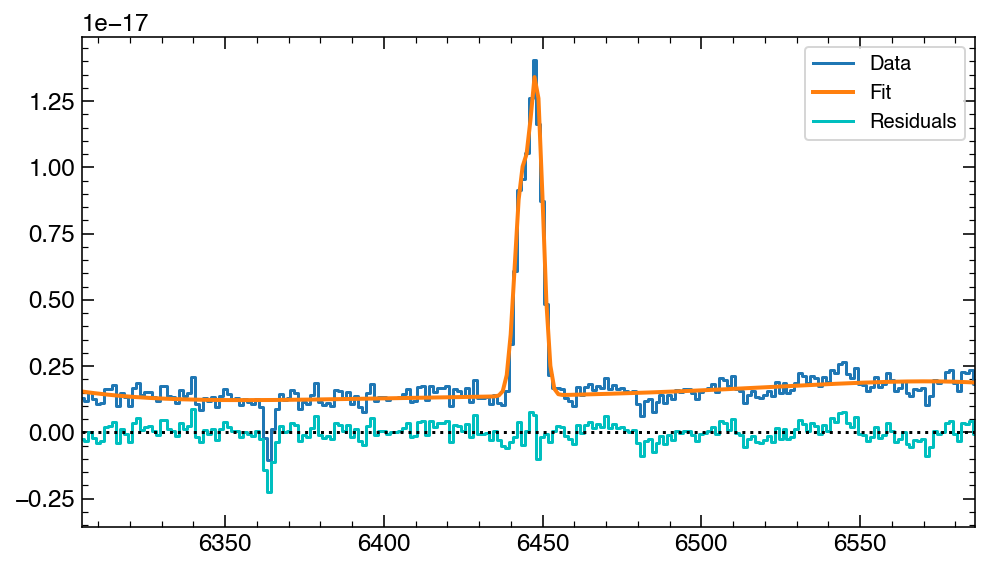

In [60]:
fig = plt.figure(figsize=(figXsize,figYsize))
ax = fig.add_subplot(111)
ax.plot(wave,flux,lw=1.5,drawstyle='steps-mid',label='Data')
ax.set_xlim(waveLimits2)

ax.plot(wave[fitWaves2],fitted_model2(wave[fitWaves2]),
        lw=2,label='Fit')
ax.plot(wave[fitWaves2],
        flux[fitWaves2]-fitted_model2(wave[fitWaves2]),
        c='c',drawstyle='steps-mid',label='Residuals')
ax.plot(waveLimits2,[0.,0],':k')
ax.legend()

*Looks pretty good!*
```

```

In [76]:
print(fitted_model2.submodel_names)
print(fitted_model2['o2a'])
print(fitted_model2['o2b'])
print(fitted_model2.parameters)
fitted_model2[0], fitted_model2[1], fitted_model2[2]

('o2a', 'o2b', 'None_0')
Model: Gaussian1D
Name: o2a
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          amplitude              mean             stddev     
    --------------------- ----------------- -----------------
    7.719784422012131e-18 6443.281625609433 2.146604365338434
Model: Gaussian1D
Name: o2b
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          amplitude              mean             stddev      
    --------------------- ----------------- ------------------
    1.140748803904346e-17 6448.094158825484 2.0221827124757783
[ 7.71978442e-18  6.44328163e+03  2.14660437e+00  1.14074880e-17
  6.44809416e+03  2.02218271e+00  1.54417964e-18  3.05281517e-19
  1.64990782e-19 -9.01190083e-20  5.02414950e-21 -4.54442539e-20]


(<Gaussian1D(amplitude=0., mean=6443.28162561, stddev=2.14660437, name='o2a')>,
 <Gaussian1D(amplitude=0., mean=6448.09415883, stddev=2.02218271, name='o2b')>,
 <Chebyshev1D(5, c0=0., c1=0., c2=0., c3=-0., c4=0., c5=-0.)>)

## What if I want to adjust a parameter based on prior information or to apply to another situation?

In [83]:
fitted_model2['o2a']

<Gaussian1D(amplitude=0., mean=6443.28162561, stddev=35., name='o2a')>

In [84]:
fitted_model2['o2a'].stddev=35.

In [85]:
fitted_model2['o2a']

<Gaussian1D(amplitude=0., mean=6443.28162561, stddev=35., name='o2a')>